Modifying KPi-ratio
-------------------

In [1]:
# basic imports and jupyter setup
import matplotlib.pyplot as plt
import numpy as np

# import solver related modules
from MCEq.core import MCEqRun

# import primary model choices
import crflux.models as pm

In [2]:
mceq = MCEqRun(
    # provide the string of the interaction model
    interaction_model="DPMJETIII191",
    # primary cosmic ray flux model
    primary_model=(pm.HillasGaisser2012, "H3a"),
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0,
)

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [3]:
# Power of energy to scale the flux
mag = 3

# obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq.e_grid

# Dictionary for results
flux = {}

cos_theta = np.array([1.0, 0.5, 0.0])
angles = np.rad2deg(np.arccos(cos_theta))


# Weight function for modification of pion and kaon distributions
def weight_fun(xmat, egrid, pname, value):
    return (1 + value) * np.ones_like(xmat)

In [4]:
# Set location to IceCube
mceq.set_density_model(("MSIS00_IC", ("SouthPole", "January")))

MCEqRun::set_density_model(): Setting density profile to MSIS00_IC ('SouthPole', 'January')
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00


In [5]:
def compute_fluxes():
    from collections import defaultdict

    flux = defaultdict(lambda: [])

    # Sum fluxes, calculated for different angles
    for theta in angles:
        mceq.set_theta_deg(theta)
        mceq.solve()
        # _conv means conventional (mostly pions and kaons)
        flux["numu_pi"].append(
            mceq.get_solution("pi_numu", mag) + mceq.get_solution("pi_antinumu", mag)
        )
        flux["numu_k"].append(
            mceq.get_solution("k_numu", mag)
            + mceq.get_solution("k_numu", mag)
            + mceq.get_solution("K0_numu", mag)
            + mceq.get_solution("K0_antinumu", mag)
        )
        flux["numu_pr"].append(
            mceq.get_solution("pr_numu", mag) + mceq.get_solution("pr_antinumu", mag)
        )
        flux["numu_mu"].append(
            mceq.get_solution("mu_numu", mag) + mceq.get_solution("mu_antinumu", mag)
        )

        flux["nue_pi"].append(
            mceq.get_solution("pi_nue", mag) + mceq.get_solution("pi_antinue", mag)
        )
        flux["nue_k"].append(
            mceq.get_solution("k_nue", mag)
            + mceq.get_solution("k_nue", mag)
            + mceq.get_solution("K0_nue", mag)
            + mceq.get_solution("K0_antinue", mag)
        )
        flux["nue_pr"].append(
            mceq.get_solution("pr_nue", mag) + mceq.get_solution("pr_antinue", mag)
        )
        flux["nue_total"].append(
            mceq.get_solution("total_nue", mag)
            + mceq.get_solution("total_antinue", mag)
        )
        flux["nue_mu"].append(
            mceq.get_solution("mu_nue", mag) + mceq.get_solution("mu_antinue", mag)
        )
        flux["numu_total"].append(
            mceq.get_solution("total_numu", mag)
            + mceq.get_solution("total_antinumu", mag)
        )
    return dict(flux)

In [6]:
mceq.unset_mod_pprod()
mceq.matrix_builder.construct_matrices(skip_decay_matrix=True)
nominal = compute_fluxes()

mceq.set_mod_pprod(2212, 211, weight_fun, ("a", 0.15))
mceq.set_mod_pprod(2212, -211, weight_fun, ("a", 0.12))
mceq.regenerate_matrices(skip_decay_matrix=True)
piup = compute_fluxes()
mceq.unset_mod_pprod()

mceq.set_mod_pprod(2212, 321, weight_fun, ("a", 0.45))
mceq.set_mod_pprod(2212, -321, weight_fun, ("a", 0.55))
mceq.regenerate_matrices(skip_decay_matrix=True)
kdown = compute_fluxes()
mceq.unset_mod_pprod()

MCEqRun::unset_mod_pprod(): Particle production modifications reset to defaults.
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 60.00
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 90.00
MCEqRun::set_mod_pprod(): 2212/211, weight_fun, ('a', 0.15)
MCEqRun::set_mod_pprod(): 2212/-211, weight_fun, ('a', 0.12)
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 60.00
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 90.00
MCEqRun::unset_mod_pprod(): Particle production modifications reset to defaults.
MCEqRun::set_mod_pprod(): 2212/321, weight_fun, ('a', 0.45)
MCEqRun::set_mod_pprod(): 2212/-321, weight_fun, ('a', 0.55)
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle =  0.00
MSIS00IceCubeCentered::set_theta(): latitude = -90.00 for zenith angle = 60.00
MSIS00IceCubeCentered::set_theta(): latitud

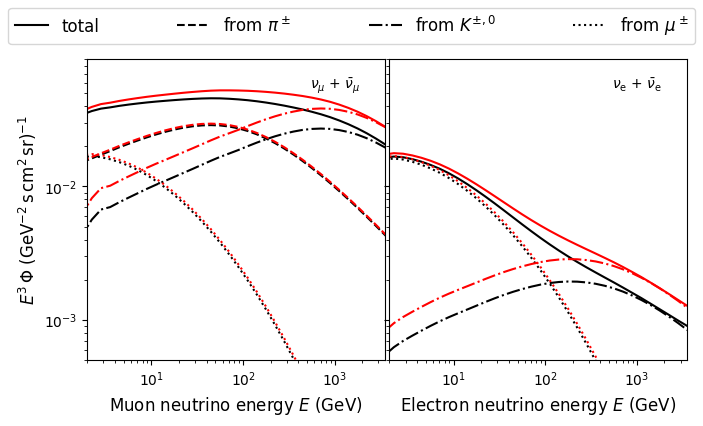

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4.3), sharex=True, sharey=True)

# Display the adjusted flux
show_correction = True

c = axes[0].loglog(e_grid, nominal["numu_total"][1], c="k")[0].get_color()
axes[0].loglog(e_grid, nominal["numu_pi"][1], c=c, ls="--")
axes[0].loglog(e_grid, nominal["numu_k"][1], c=c, ls="-.")
axes[0].loglog(e_grid, nominal["numu_mu"][1], c=c, ls=":")
if show_correction:
    c = axes[0].loglog(e_grid, kdown["numu_total"][1], c="r")[0].get_color()
    axes[0].loglog(e_grid, kdown["numu_pi"][1], c=c, ls="--")
    axes[0].loglog(e_grid, kdown["numu_k"][1], c=c, ls="-.")
    axes[0].loglog(e_grid, kdown["numu_mu"][1], c=c, ls=":")
c = axes[1].loglog(e_grid, nominal["nue_total"][1], c="k")[0].get_color()
axes[1].loglog(e_grid, nominal["nue_pi"][1], c=c, ls="--")
axes[1].loglog(e_grid, nominal["nue_k"][1], c=c, ls="-.")
axes[1].loglog(e_grid, nominal["nue_mu"][1], c=c, ls=":")
if show_correction:
    c = axes[1].loglog(e_grid, kdown["nue_total"][1], c="r")[0].get_color()
    axes[1].loglog(e_grid, kdown["nue_pi"][1], c=c, ls="--")
    axes[1].loglog(e_grid, kdown["nue_k"][1], c=c, ls="-.")
    axes[1].loglog(e_grid, kdown["nue_mu"][1], c=c, ls=":")
axes[1].set_xlim(2.0, 3500)
axes[1].set_ylim(5e-4, 9e-2)
axes[0].set_xlabel("Muon neutrino energy $E$ (GeV)", fontsize="large")
axes[1].set_xlabel("Electron neutrino energy $E$ (GeV)", fontsize="large")
axes[0].set_ylabel(
    r"$E^3\,\Phi$ (GeV$^{-2}\,$s$\,$cm$^{2}\,$sr$)^{-1}$", fontsize="large"
)


axes[0].text(
    0.75,
    0.9,
    r"$\nu_\mu$ + $\bar{\nu}_\mu$",
    transform=axes[0].transAxes,
    # fontsize="large",
)
axes[1].text(
    0.75,
    0.9,
    r"$\nu_{\rm e}$ + $\bar{\nu}_{\rm e}$",
    transform=axes[1].transAxes,
    # fontsize="large",
)
# Make legend for interaction models
figleg_lines, figleg_labels = [], []
for m, ls in zip(
    ["total", r"from $\pi^\pm$", r"from $K^{\pm,0}$", r"from $\mu^\pm$"],
    ["-", "--", "-.", ":"],
):
    figleg_lines.append(plt.plot([0, 0], [0, 0], ls=ls, color="k")[0])
    figleg_labels.append(m)
plt.figlegend(
    figleg_lines,
    figleg_labels,
    loc="upper center",
    mode="expand",
    ncol=4,
    frameon=True,
    fontsize="large",
)
plt.tight_layout(
    rect=[0.0, 0.0, 1.0, 0.9],
    w_pad=0.0,
    h_pad=0.5,
)
# plt.savefig('flux_components.pdf',dpi=300)